In [1]:
import numpy
import pandas as pd
import torch
import numpy as np
#from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os,random
import torchvision.transforms as T
import csv
import cv2
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

#my imports

import train

from torch.utils.tensorboard import SummaryWriter #tensorboard --logdir log --bind_all


In [2]:
# 获取当前路径
current_directory = os.getcwd()
print("当前路径:", current_directory)

# 定义要变更的目标路径
#target_directory = "D:/AI/boltpd"

# 使用os.chdir()来变更路径
#os.chdir(target_directory)

# 再次获取当前路径，此时它应该是目标路径
#new_current_directory = os.getcwd()
#print("变更后的路径:", new_current_directory)


当前路径: /home/br-python/Documents/chen/boltpd


In [3]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.tensor([1, 2, 3]).to(device)
print(x.device)

2.0.0+cu117
True


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    pathDir = os.listdir(dir)    #取图片的原始路径
    filenumber=len(pathDir)
    rate=1    #自定义抽取图片的比例，比方说100张抽10张，那就是0.1
    picknumber=int(filenumber*rate) #按照rate比例从文件夹中取一定数量图片
    sample = random.sample(pathDir, picknumber)  #随机选取picknumber数量的样本图片

    file = pd.read_csv(r'./label/label-2024pretension.csv') # 读取csv数据
    file=np.array(file)#注意数据会跳过第一行，第一行为索引标题
    labels=[]
    img_data = []
    f0 = None
    for file_name in sample:
        if f0 is None:
            f0 = os.path.join(dir, file_name)
        if file_name != "Thumbs.db":
            if int(file_name[-9:-4]) > 9900 or int(file_name[-9:-4]) < 107:
                img_dir = os.path.join(dir, file_name)
                img = cv2.imread(img_dir)
                #ref_img = cv2.imread('./database/c_data/bolt1/DSC01686.JPG')
                #img = cv2.subtract(img, ref_img)
                #img1 = cv2.subtract(img,cv2.imread(f0))
                img = cv2.resize(img, (800, 800))   # /5 resize img
                #img_gray = cv.cvtColor(img,cv.COLOR_RniGB2GRAY)
                pimg = Image.fromarray(img)
                img_data.append(pimg)
                #img_data.append(file_name)
                for item in file:       #add label, from 1row
                    sh = item[1]
                    if file_name[-9:-4] == sh[-9:-4]:
                        labels.append(item[0]/230)#
                        #labels.append(item[1])
    labels = torch.tensor(labels)
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1)
    return img_data,labels

class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i]) #.to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)

Inport data

30 30
120 120
torch.Size([2, 1, 800, 800])
torch.Size([2, 1])


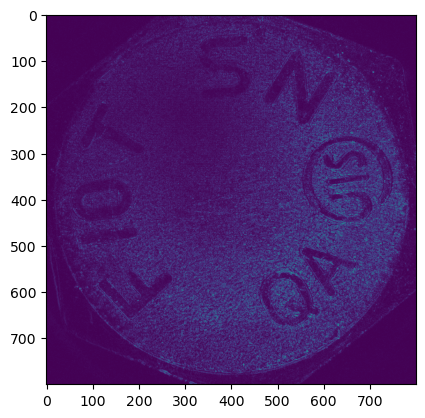

In [5]:
normMean = [0.5]
normStd = [0.5]
transform = transforms.Compose([
    #transforms.Resize(450),
    #transforms.CenterCrop(448),
    transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]
    #transforms.Normalize(normMean, normStd)
    ])

traindir= './database/2024preten/diffimg/'
validdir='./database/2024preten/diff-test/'
train_rdata, train_label = generate_dataset(traindir)
valid_rdata, valid_label = generate_dataset(validdir)
print(len(valid_rdata),len(valid_label))
print(len(train_rdata),len(train_label))

# 也可以再定义train_transform加入一些数据增强
train_data = MyDataset(train_rdata, train_label, transform=transform)
valid_data = MyDataset(valid_rdata, valid_label, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=2, shuffle=True)

dataiter=iter(train_loader)
images, labels = dataiter.__next__()
print(images.shape)
print(labels.shape)
topic = T.ToPILImage()
imm1 = topic(images[0])
vimg, vlabels = dataiter.__next__()
plt.imshow(topic(vimg[0]))


# Define model

In [6]:
#from net import ResNet, Bottleneck
#from SEBlock import SEBlock
from loss_func import HuberLossPena
from mynet import ModResdic, Bottleneck, ModResv1, MultiScaleFusion
#import net

    
# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5000
# 隐含层中神经元的个数
#NEURON_NUM = 500
#OUTPUT_FEATURE_DIM = 1
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.00001

# 定义模型
net = ModResv1(block=Bottleneck, block_num=[3,4,6,3],num_classes=1)
#net = ResNet152(block=Bottleneck152,layers=[3, 4, 36, 3],num_classes=1,in_dim=1)
casename='202402'
writer = SummaryWriter("./log/"+casename) #tensorboard

#print(net)
writer.add_graph(net, images)
writer.close()

# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(net.parameters(),lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = HuberLossPena(delta=0.1, penalty_weight=3.0)
#loss_func = nn.MSELoss()
#loss_func = nn.CrossEntropyLoss() #定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

# EXCUETE MODEL

In [7]:

if __name__ == "__main__":

    torch.cuda.empty_cache()
    # Let's build our model
    train.train(100,device,net)
    print('Finished Training')
    #Epochごとのlossの保存
    torch.save(net, "./result/"+casename+"/"+casename+".pt")
    # 保存网络中的参数, 速度快，占空间少
    #torch.save(net.state_dict(),'case-1-p.pt')
    #--------------------------------------------------
    #针对上面一般的保存方法，加载的方法分别是：
    # model_dict=torch.load(PATH)
    # model_dict=model.load_state_dict(torch.load(PATH))
    # Test which classes performed well
    train.testAccuracy()

    # Let's load the model we just created and test the accuracy per label
    # model = net()
    # path = "myFirstModel.pth"
    # model.load_state_dict(torch.load(path))


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Visualization

In [ ]:
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
torch.cuda.empty_cache()
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
video=cv2.VideoWriter('./multibolt/video/valid.avi',-1,20,(448,448))  

with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        predata = net(images)
        #predata, labedata = predict(net, valid_loader)
        loss=loss_func(predata, labels)
        loss += loss.item()
        x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
        y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
        preloss=loss/(i+1)

x0=x*116
y0=y*116

In [ ]:

x=np.linspace(0,120,120)
y=np.linspace(0,120,120)

from scipy.optimize import curve_fit
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc
import seaborn as sns

plt.figure()

plt.xlim(0,120)
plt.ylim(0,120)
#y_err1=1.1*train_label.data.cpu().numpy()
#y_err2=0.9*train_label.data.cpu().numpy()
#n = len(y)
xx=x0
yy=y0
n = len(yy)

def f(x, a, b):
    return np.multiply(a, x) + b

#popt, pcov = curve_fit(f, x, y)
popt, pcov = curve_fit(f, xx, yy)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
#r2 = 1.0-(sum((y0-f(x0,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
r2 = 1.0-(sum((yy-f(xx,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))
print('testdataNum:' + str(i+1))
print('preloss:' + str(preloss))

# calculate parameter confidence interval
a,b = unc.correlated_values(popt, pcov)
print('Uncertainty')
print('a: ' + str(a))
print('b: ' + str(b))



mse = np.mean((x0 - y0) ** 2)
rmse = np.sqrt(np.mean((x0 - y0) ** 2))
msle = np.mean((np.log1p(x0) - np.log1p(y0))** 2)
mae = np.mean(np.abs(x0 - y0))
r2 = 1 - np.mean((x0 - y0) ** 2) / np.mean((x0 - x0.mean()) ** 2)
print('MSE:=',mse,'| RMSE:',rmse,'|msle:',msle,'|mae:',mae,'|r2:',r2)

# calculate regression confidence interval
px=np.linspace(0,120,120)
py=a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

#plt.fill_between(df['temperature'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=.1, label='Prediction interval')
# prediction band (95% confidence)

# plot the regression
#plt.plot(px, nom, c='black', label='Regression Line')

lpb, upb = predband(px, xx, yy, popt, f, conf=0.95)


#lpb=[x+25 for x in px]
#upb=[x-25 for x in px]

# uncertainty lines (95% confidence)
#plt.plot(px, nom - 1.96 * std, c='orange',\
#        label='95% Confidence Region')
#plt.plot(px, nom + 1.96 * std, c='orange')

# prediction band (95% confidence)
#plt.plot(px, lpb, 'k--',label='95% Prediction Band')
#plt.plot(px, upb, 'k--')
#plt.fill_between(px,lpb,upb, alpha=.1,)

# plot data

plt.plot(x0,y0,'ko',alpha=0.6,label='Data', mfc='none')


plt.plot(x, y, c='black')
#plt.plot(x*0.9,y,'k--',label='90% Error interval')
#plt.plot(x*1.1,y,'k--')
#plt.fill_between(x,x*1.1,x*0.9, alpha=.1)
plt.legend(loc='lower right')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
text='$R^2$: {:.2f} \n$MSE$: {:.1f} \n$RMSE$: {:.1f} \n$MAE$: {:.1f}'.format(r2,mse,rmse,mae)
plt.text(5,85,text)
plt.savefig("./result/"+casename+"/"+casename+'predictpreload.png', dpi=1200)
plt.show()

In [ ]:
test_rdata, test_label = generate_dataset(testdir)
test_data = MyDataset(test_rdata, test_label, transform=transform)
test_loader = DataLoader(dataset=test_data, batch_size=4, shuffle=True)
x=[]
y=[]
np.array(x)
np.array(y)
net.eval()
# net=torch.load('')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        labels = Variable(labels.to(device))
        predata = net(images)
        #predata, labedata = predict(net, valid_loader)
        loss=loss_func(predata, labels)
        loss += loss.item()
        x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
        y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
        preloss=loss/(i+1)


In [ ]:
x0=np.linspace(0,120,120)
y0=np.linspace(0,120,120)
plt.plot(x0, y0, c='black')
plt.plot(x*116,y*116,'ko',alpha=0.6,label='Data', mfc='none')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
plt.show
plt.savefig("./result/"+casename+"/"+casename+'testother.png', dpi=1200)

In [ ]:
case27=torch.load('./result/case2-7/case2-7.pt')
print(case27)

# Creat video

In [ ]:
net27=torch.load('./result/case2-7/case2-7.pt')
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
torch.cuda.empty_cache()
net.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
codec = cv2.VideoWriter_fourcc(*"DIVX")
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video=cv2.VideoWriter('valid.avi',fourcc,10,(448,448))  
c = (0,0,255)
with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader, 0):
        #images, labels = dataiter.next()
        # 输入数据进行预测
        # get the inputs
        images = Variable(images.to(device))
        
        labels = Variable(labels.to(device))
        predata = net27(images)
        #predata, labedata = predict(net, valid_loader)
        outproload=predata*116
        outlabel=labels*116
        erro=(outlabel-outproload)*100/outproload
        loss=loss_func(predata, labels)
        loss += loss.item()
        tmp = images[0,:,:,:].permute(1, 2, 0)
        rgb=tmp.to('cpu').detach().numpy()
        rgb = (rgb*255.0).astype(np.uint8)
        img = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

        x=np.append(x,[i[0] for i in labels.data.cpu().numpy()])
        y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
        preloss=loss/(i+1)
        txt1 = 'Axial Force='+str(np.round(outproload.data.cpu().numpy()))+'/'+str(np.round(outlabel.data.cpu().numpy()))
        txt2= ' Error='+str(np.round(erro.data.cpu().numpy()))+'%'
        font = cv2.FONT_HERSHEY_SIMPLEX
        cat_size = cv2.getTextSize(txt, font, 2, 5)[0]
        cv2.rectangle(img, (25, 15), (430, 420), c , 2)
        #cv2.rectangle(img,(50,50 - cat_size[1] - 2),(box[0] + cat_size[0],400 - 2), c, -1)
        cv2.putText(img, txt1, (20, 50), font, 1, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
        cv2.putText(img, txt2, (20, 80), font, 1, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
        #plt.figure(figsize=(450,450))
        plt.imshow(img)
        video.write(img)
video.release()

In [ ]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img 

i, (images, labels) = enumerate(valid_loader, 0)
#a= unnorm(images[14,:,:,:]).permute(1, 2, 0)
print(images.shape)
print(a.shape[1])